Mounted at /content/drive
Distribusi total:
label
PROMO_JUDOL    906
NORMAL         900
RISKY          252
Name: count, dtype: int64

Distribusi data real saja:
label
PROMO_JUDOL    906
NORMAL         900
RISKY          153
Name: count, dtype: int64

Distribusi data dengan augmentasi:
label
PROMO_JUDOL    906
NORMAL         900
RISKY          252
Name: count, dtype: int64

===== Tanpa Augmentasi =====

=== Validation Report ===
              precision    recall  f1-score   support

      NORMAL      0.896     0.956     0.925        90
 PROMO_JUDOL      0.942     0.900     0.920        90
       RISKY      1.000     0.875     0.933        16

    accuracy                          0.923       196
   macro avg      0.946     0.910     0.926       196
weighted avg      0.925     0.923     0.923       196


=== Test Report ===
              precision    recall  f1-score   support

      NORMAL      0.897     0.967     0.930        90
 PROMO_JUDOL      0.943     0.901     0.921        91
   

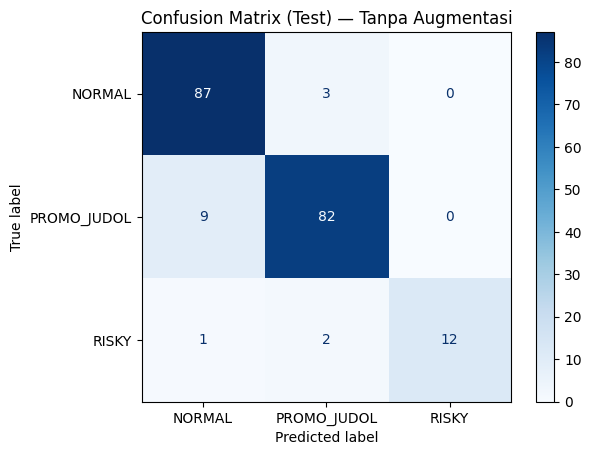


===== Dengan Augmentasi =====

=== Validation Report ===
              precision    recall  f1-score   support

      NORMAL      0.915     0.956     0.935        90
 PROMO_JUDOL      0.954     0.922     0.938        90
       RISKY      1.000     0.962     0.980        26

    accuracy                          0.942       206
   macro avg      0.956     0.946     0.951       206
weighted avg      0.943     0.942     0.942       206


=== Test Report ===
              precision    recall  f1-score   support

      NORMAL      0.889     0.978     0.931        90
 PROMO_JUDOL      0.976     0.879     0.925        91
       RISKY      0.960     0.960     0.960        25

    accuracy                          0.932       206
   macro avg      0.941     0.939     0.939       206
weighted avg      0.936     0.932     0.932       206



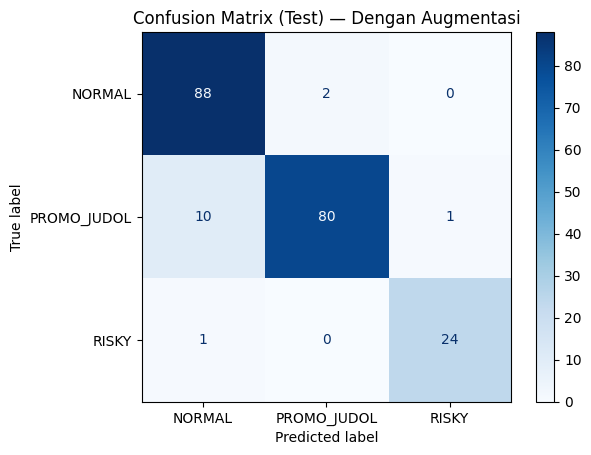

['/content/drive/My Drive/Colab Notebooks/tfidf_char_vectorizer_with_aug.joblib']

In [1]:
# =========================================
# Baseline_tfidf_lr_compare_aug.ipynb
# Membandingkan baseline dengan & tanpa augmentasi
# =========================================

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
data_path = "/content/drive/My Drive/Colab Notebooks/Sentry-ID/Dataset/dataset.csv"
df = pd.read_csv(data_path)

print("Distribusi total:")
print(df['label'].value_counts())

# --- Pisahkan skenario ---
df_real = df[df['is_augmented'] == 0]   # hanya data asli
df_all  = df                           # semua data (real + augmented)

print("\nDistribusi data real saja:")
print(df_real['label'].value_counts())

print("\nDistribusi data dengan augmentasi:")
print(df_all['label'].value_counts())

# =========================================
# Fungsi pipeline training & evaluasi
# =========================================
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import joblib

def run_baseline(df, name=""):
    print(f"\n===== {name} =====")

    # Split stratified
    train, temp = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
    val, test = train_test_split(temp, test_size=0.5, stratify=temp['label'], random_state=42)

    # TF-IDF word & char
    vec_word = TfidfVectorizer(ngram_range=(1,2), max_features=40000)
    vec_char = TfidfVectorizer(analyzer="char", ngram_range=(3,5), max_features=10000)

    X_train = hstack([vec_word.fit_transform(train['comment']), vec_char.fit_transform(train['comment'])])
    X_val   = hstack([vec_word.transform(val['comment']),  vec_char.transform(val['comment'])])
    X_test  = hstack([vec_word.transform(test['comment']), vec_char.transform(test['comment'])])

    y_train, y_val, y_test = train['label'], val['label'], test['label']

    # Logistic Regression
    clf = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1, C=2.0)
    clf.fit(X_train, y_train)

    # Evaluation
    print("\n=== Validation Report ===")
    y_val_pred = clf.predict(X_val)
    print(classification_report(y_val, y_val_pred, digits=3))

    print("\n=== Test Report ===")
    y_test_pred = clf.predict(X_test)
    print(classification_report(y_test, y_test_pred, digits=3))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix (Test) — {name}")
    plt.show()

    return clf, vec_word, vec_char

# =========================================
# Jalankan kedua skenario
# =========================================
clf_real, vec_word_real, vec_char_real = run_baseline(df_real, name="Tanpa Augmentasi")
clf_all, vec_word_all, vec_char_all    = run_baseline(df_all, name="Dengan Augmentasi")

# (Opsional) Simpan model dari skenario dengan augmentasi
joblib.dump(clf_all, "/content/drive/My Drive/Colab Notebooks/logreg_model_with_aug.joblib")
joblib.dump(vec_word_all, "/content/drive/My Drive/Colab Notebooks/tfidf_word_vectorizer_with_aug.joblib")
joblib.dump(vec_char_all, "/content/drive/My Drive/Colab Notebooks/tfidf_char_vectorizer_with_aug.joblib")

